In [12]:
#import pycbc.noise
#import pycbc.psd
import matplotlib.pyplot as plt
import numpy as np
import pydd
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from pydd.analysis import calculate_SNR, calculate_match_unnormd_fft, get_match_pads, loglikelihood_fft
from pydd.binary import (
    Binary,
    Psi,
    amp,
    DynamicDress,
    MSUN,
    PC,
    Phi_to_c,
    _Phi_to_c_indef,
    VacuumBinary,
    convert,
    get_M_chirp,
    get_rho_s,
    get_f_isco,
    get_rho_6,
    get_f_range,
    get_m_1,
    make_dynamic_dress,
    make_vacuum_binary,
    t_to_c,
    YR,
    amp,
    d2Phi_dt2,
    phasePN,
    G,
    C,
    get_a_v
)

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange
import latex

from scipy.optimize import minimize_scalar


In [13]:
# Set detector
detector = "et"

# Set noise and other globals based on detector
if detector == "et":
    from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET

    T_OBS = 1 * YR / 52
    SNR_THRESH = 8.0
    TITLE = "Einstein Telescope"
    
elif detector == "ce":
    from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Cosmic Explorer"
elif detector == "aLIGO":
    from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "aLIGO"
elif detector == "LISA":
    from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

    T_OBS = 1 * YR #/12 / 4.34524 / 7
    SNR_THRESH = 15.0
    TITLE = "LISA"

In [15]:
def get_signal_system() -> Tuple[DynamicDress, Tuple[float, float]]:
    """
    Creates a dark dress with correct SNR for given detector.
    
    Returns:
        The dark dress and frequency range corresponding to an observing time
        of ``T_OBS`` before coalescence.
    """
    M_1 = np.array(1 * MSUN)
    M_2 = np.array(1e-3 * MSUN)
    M_CHIRP = get_M_chirp(M_1, M_2)
    Q = M_2 / M_1
    GAMMA_S = 9 / 4
    RHO_6 = 1.396e13 * (M_1/MSUN)**(3/4) * MSUN/PC**3
    TT_C = np.array(0.0)
    F_C = get_f_isco(M_1)
    PHI_C = np.array(0.0)
    _DD_D = DynamicDress(
        GAMMA_S,
        RHO_6,
        get_M_chirp(M_1, M_2),
        M_2 / M_1,
        PHI_C,
        tT_c=TT_C,
        dL=np.array(100e6 * PC),
        f_c=get_f_isco(M_1),
    )

    # Frequency range and grids
    F_RANGE_D = get_f_range(_DD_D, T_OBS,bracket = (1,10))
    print(F_RANGE_D)
    FS = np.linspace(
        max(F_RANGE_D[0], f_range_n[0]), min(F_RANGE_D[1], f_range_n[1]), 10_000
    )

    # Get dL such that SNR = threshold
    _fn = lambda dL: calculate_SNR(
            DynamicDress(
                _DD_D.gamma_s,
                _DD_D.rho_6,
                _DD_D.M_chirp,
                _DD_D.q,
                _DD_D.Phi_c,
                _DD_D.tT_c,
                dL,
                _DD_D.f_c,
            ),
            FS,
            S_n,
        )
    
    print(_fn(100000e6))
    res = root_scalar(
        lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC)
    )
    assert res.converged
    DL = res.root

    # Signal system
    DD_D = DynamicDress(
        _DD_D.gamma_s,
        _DD_D.rho_6,
        _DD_D.M_chirp,
        _DD_D.q,
        _DD_D.Phi_c,
        _DD_D.tT_c,
        DL,
        _DD_D.f_c,
    )

    return DD_D, F_RANGE_D

In [16]:
DD_D, F_RANGE_D = get_signal_system()

# FS = jnp.linspace(*F_RANGE_D, 10_000)  # coarse grid
FS = np.linspace(*F_RANGE_D, 100_000)  # finer grid 
PAD_LOW, PAD_HIGH = get_match_pads(FS)  # padding for likelihood calculation

(13.660598117287558, 4397.009834378759)
287996081394006.06


In [21]:
def waveform(params_h: Binary, fs, S_n = S_n):
    wf_h = amp(fs, params_h) * np.exp(1j * Psi(fs, params_h))
    return wf_h

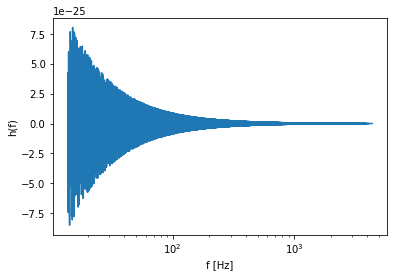

In [25]:
plt.semilogx(FS, waveform(DD_D,FS,S_n))
plt.xlabel('f [Hz]')
plt.ylabel('h(f)')
plt.show()